# objectives - get basic model tested after variance inflation factor used for feature selection

- check feature importance afterwards, 

- set up for advanced model tuning 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns

from utils import save_file

In [3]:
df = pd.read_csv('../../data/model/final_df.csv')
df.rename(columns={"Asian or Asian/Pacific Islander - female [Public School] 2020-21":'APA_F',
                  'Current\nExpense Per ADA':'Current_Expense_per_ADA'}
       ,inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52665 entries, 0 to 52664
Data columns (total 23 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Mean Scale Score                             52665 non-null  float64
 1   Total Tested with Scores at Reporting Level  52665 non-null  float64
 2   Demographic Name                             52665 non-null  object 
 3   Student Group                                52665 non-null  object 
 4   District Type                                52665 non-null  object 
 5   Test ID                                      52665 non-null  object 
 6   School Type                                  52665 non-null  object 
 7   Education_type                               52665 non-null  object 
 8   Charter_School                               52665 non-null  int64  
 9   Low Grade                                    52665 non-null  object 
 10

In [4]:
df.head()

,Mean Scale Score,Total Tested with Scores at Reporting Level,Demographic Name,Student Group,District Type,Test ID,School Type,Education_type,Charter_School,Low Grade,...,Pupil/Teacher-Ratio,Hispanic_Female,Black_or_AA_F,APA_F,Avg_21,Average Salary Paid,Current_Expense_per_ADA,est_num_u17_pov,Grocery_3mile,Grocery_dist
0,2579.7,106.0,All Students,All Students,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
1,2582.4,56.0,Male,Gender,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
2,2577.0,50.0,Female,Gender,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
3,2600.2,91.0,IFEP and EO (Initial fluent English proficient...,English-Language Fluency,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
4,2614.4,24.0,RFEP (Reclassified fluent English proficient),English-Language Fluency,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0


In [5]:
## add random variable to compare variable inportance too 

In [6]:
df['random'] = np.random.random(size = len(df))

In [7]:
df.columns

Index(['Mean Scale Score', 'Total Tested with Scores at Reporting Level',
       'Demographic Name', 'Student Group', 'District Type', 'Test ID',
       'School Type', 'Education_type', 'Charter_School', 'Low Grade',
       'Free_Meal_count', 'Latitude', 'FTE_Teachers', 'Pupil/Teacher-Ratio',
       'Hispanic_Female', 'Black_or_AA_F', 'APA_F', 'Avg_21',
       'Average Salary Paid', 'Current_Expense_per_ADA', 'est_num_u17_pov',
       'Grocery_3mile', 'Grocery_dist', 'random'],
      dtype='object')

## Decrease categories for one hote encoding 

In [8]:
df['Low Grade'] = df['Low Grade'].replace({'P':'K','5,4,3,2,1':'6',
                                           '11 or 8':'11,10,8',
                                          '10':'11,10,8'})

In [9]:
df['Low Grade'].value_counts()

9          42218
K           5085
6           2536
7           1941
11,10,8      885
Name: Low Grade, dtype: int64

In [10]:
df['Low Grade'].unique().tolist()

['6', '9', 'K', '7', '11,10,8']

## One hot encode categotical columns 

In [11]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Low Grade']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Low Grade'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Low Grade',inplace=True,axis=1)
df.shape

(52665, 27)

In [12]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Test ID']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Test ID'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Test ID',inplace=True,axis=1)
df.shape

(52665, 27)

In [13]:
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Demographic Name']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Demographic Name'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Demographic Name',inplace=True,axis=1)
df.shape

(52665, 56)

In [18]:
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['District Type']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['District Type'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('District Type',inplace=True,axis=1)
df.shape

(52665, 59)

In [19]:
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Education_type']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Education_type'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Education_type',inplace=True,axis=1)
df.shape

(52665, 63)

In [20]:
df.shape

(52665, 63)

In [21]:
X = df.drop(columns=['Mean Scale Score',
                # redundent columns 
                     'Student Group',  'School Type', ])

y = df['Mean Scale Score']

In [22]:
 X_train, X_test, y_train, y_test = train_test_split(  X, y ,
                                                     test_size=0.2, random_state=42)
    
    

### using a dummy model with the mean scores predicts 0% of the variance in the data set and is off on average of 62 points 

## Create pipeline for linear model 

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [24]:
lm = LinearRegression().fit(X_tr_scaled,y_train)

In [25]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [26]:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.6545211233897378, 0.6541104771813522)

In [27]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(35.037602140530346, 34.916417506802496)

In [28]:
X_train.shape

(42132, 60)

In [29]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression,k=40),
    LinearRegression()
)

In [30]:
pipe.fit(X_train,y_train)
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [31]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6447161596229172, 0.644658839470919)

In [32]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(35.48161211596395, 35.39462084529474)

In [33]:
cv_results = cross_validate(pipe, X_train,y_train, cv=5)
cv_scores = cv_results['test_score']
np.mean(cv_scores), np.std(cv_scores)

(0.6433582769836337, 0.005685183939547486)

## cross validation does not increase r2 , small variation between models 

## look to use grid search on number of features for hypter paramter tuning 

In [34]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

In [37]:
lr_grid_cv = GridSearchCV(pipe,param_grid= grid_params, cv=5, n_jobs=-1)

In [38]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fcf85bf8310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [39]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [40]:
lr_grid_cv.best_params_

{'selectkbest__k': 60}

In [41]:
lr_grid_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=60,
                             score_func=<function f_regression at 0x7fcf85bf8310>)),
                ('linearregression', LinearRegression())])

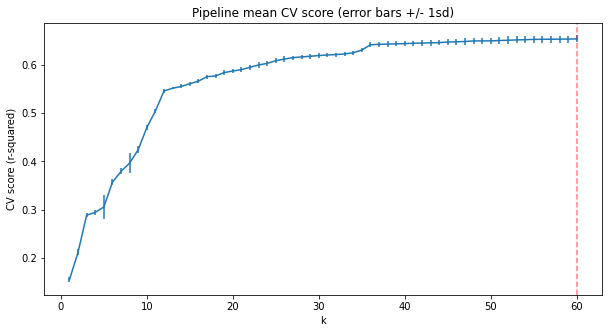

In [42]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

# linear model wants to use all of the features for best cv score 

In [48]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
# pd.Series(coefs, index=features).sort_values(ascending=False)

In [57]:
coefficients = pd.DataFrame(coefs, 
     index = features, columns =['coef']).sort_values(by='coef',ascending=False)
coefficients

,coef
FTE_Teachers,14.726082
Avg_21,12.943649
Pupil/Teacher-Ratio,12.828182
Demographic Name_Asian,11.466314
Demographic Name_Graduate school/Post graduate,7.832935
Demographic Name_IFEP (Initial fluent English proficient),7.145371
APA_F,6.119249
Demographic Name_White,5.720445
Total Tested with Scores at Reporting Level,5.633951
Demographic Name_Filipino,5.364389


## really interesting take aways about positive and negative coeeficents to compare to random forest model next 

In [49]:
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

             

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [50]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))


R^2 Training Score: 0.99 
OOB Score: 0.92 
R^2 Validation Score: 0.93


In [51]:
y_te_rf_pred=rf.predict(X_test)

In [52]:
r2_score(y_test,y_te_rf_pred)

0.9265396440790299

## over fitting with OOB and validation much lower than training 

In [53]:
# https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/feature_importance.ipynb

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    fig ,ax = plt.subplots(figsize=(12,12))
    fig = sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)
    sns.despine()

In [54]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp[:20]

,feature,feature_importance
0,Education_type_Continuation School,0.155294
1,APA_F,0.127233
2,Avg_21,0.068584
3,Hispanic_Female,0.061726
4,Pupil/Teacher-Ratio,0.057696
5,Test ID_Mathematics,0.054170
6,Demographic Name_Reported disabilities,0.047443
7,Free_Meal_count,0.042787
8,Demographic Name_EL (English learner),0.036999
9,Demographic Name_ELs enrolled 12 months or more,0.036346


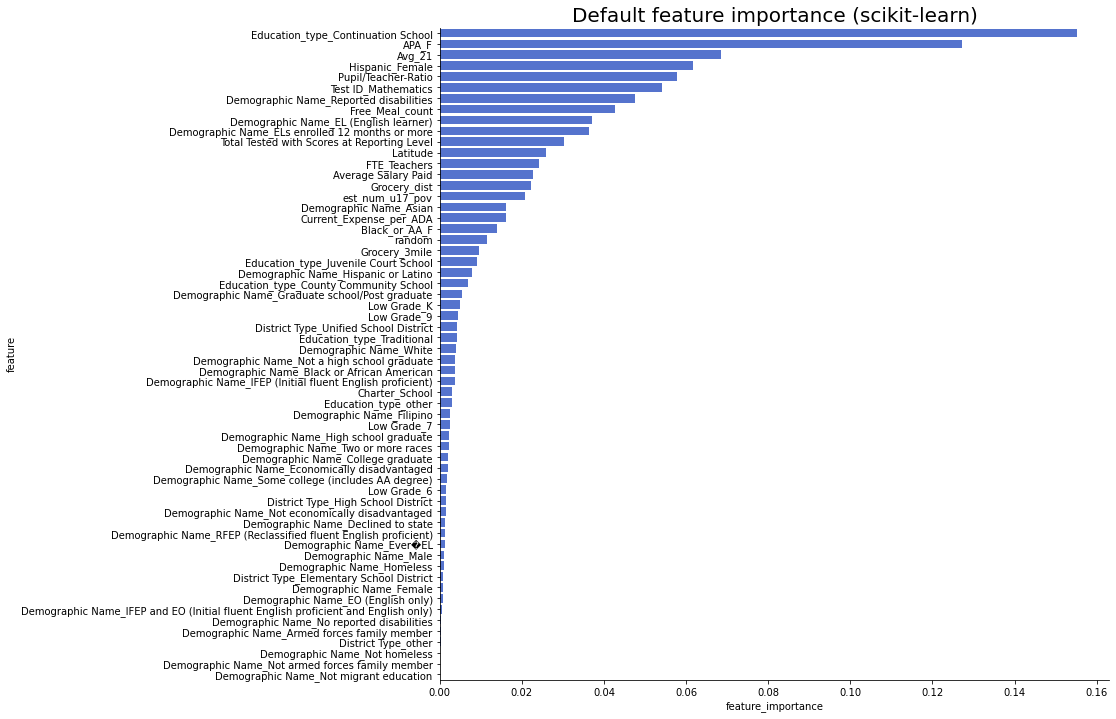

In [55]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

## RF pipeline for hyperparamter tunig 

In [58]:
rf_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42,
                            max_depth=None )
    )

In [59]:
rf_cv_results = cross_validate(rf_pipe, X_train, y_train, cv =5)

In [60]:
rf_cv_results

{'fit_time': array([45.18751121, 44.91428494, 44.73063087, 45.80229235, 44.36784601]),
 'score_time': array([0.43818998, 0.42923903, 0.42859101, 0.47821164, 0.44008112]),
 'test_score': array([0.92558934, 0.91741628, 0.92018334, 0.92242834, 0.92055135])}

In [61]:
rf_cv_scores = rf_cv_results['test_score']
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9212337294361042, 0.0027033443126980067)

In [62]:
n_est = [int(n) for n in np.logspace(1,3,10)]
n_est[:8]

[10, 16, 27, 46, 77, 129, 215, 359]

In [63]:
grid_params = {
    'n_estimators': n_est[:5],
#     'StandardScaler':[StandardScaler(),None],
    'max_depth':[None,2,3,4,6]    
}

In [64]:
rf_grid_cv = GridSearchCV(rf_pipe, param_grid= grid_params, cv=5, n_jobs=-1)


In [65]:
rf_grid_cv.fit(X_train,y_train)
rf_grid_cv.best_params_

ValueError: Invalid parameter max_depth for estimator Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
RandomForestRegressor().get_params().keys()

In [ ]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

In [ ]:
np.mean(rf_best_scores), np.std(rf_best_scores)

In [ ]:
rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_

In [ ]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [ ]:
# rf_feat_imps

In [ ]:
# Use select from model to remove features below random threshold to simplify model 

In [ ]:
from sklearn.feature_selection import SelectFromModel


In [ ]:
model = SelectFromModel(rf, 
                        threshold=0.012, # should remove random and all below 
                       )

In [ ]:
model.fit(X_train,y_train)

In [ ]:
selected_feat = X_train.columns[(model.get_support())]
selected_feat

In [ ]:
importances = pd.Series(model.estimator_.feature_importances_,
          index=X_train.columns).sort_values(ascending=False)
importances[selected_feat].sort_values().plot(kind='barh')
plt.show()

## of cultural groups asain pacific islanders and hispanics have the highest feature importances in the model 

##  Of features not associated by economic group model can be tested to see what change in average housing price, pupil teacher ratio , free meal count, average salary paid and fte teachers effects different schools in the same district when changes in these featuers are modeled. 

In [ ]:
new_X_tr = model.transform(X_train)
new_X_te = model.transform(X_test)

In [ ]:
new_X_tr.shape

In [ ]:
rf_pipe.fit(new_X,y_train)

In [ ]:
print('R^2 Training Score: {:.2f}  \nR^2 Validation Score: {:.2f}'.format(rf_pipe.score(new_X_tr, y_train), 
#                                                                                              rf_pipe.oob_score_,
                                                                                             rf_pipe.score(new_X_te, y_test)))


## simplified model lost 6 % training r2 score but only usues 19 features instead of 52 

gridsearch cv could be run on new cut down set to see if model performance can be increased 

In [ ]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()